### Examples for using Google Cloud Storage and BigQuery 

This notebook provides a guide to getting started with using GCS and BigQuery in a PySpark Jupyter Notebook on Dataproc

### Create Dataproc Cluster

Use `gcloud beta` in Cloud Shell or locally to create a dataproc cluster with the correct configuration and python libraries to work with Google Cloud Storage and BigQuery

```
REGION=us-east1
CLUSTER_NAME=jupyter-cluster-name
BUCKET=bucket-name
gcloud beta dataproc clusters create ${CLUSTER_NAME} \
  --region=${REGION} \
  --image-version=preview \
  --bucket=$BUCKET \
  --optional-components=ANACONDA,JUPYTER \
  --enable-component-gateway \
  --metadata 'PIP_PACKAGES=google-cloud-bigquery google-cloud-storage' \
  --initialization-actions \
gs://goog-dataproc-initialization-actions-${REGION}/python/pip-install.sh
```

### Python 3 Kernel

Use a Python 3 kernel (not PySpark) to allow you to configure the SparkSession in the notebook and include the [spark-bigquery-connector](https://github.com/GoogleCloudDataproc/spark-bigquery-connector) required to use the [BigQuery Storage API](https://cloud.google.com/bigquery/docs/reference/storage).

### Scala Version

Check what version of Scala you are running so you can include the correct spark-bigquery-connector jar 

In [1]:
!scala -version

Scala code runner version 2.12.10 -- Copyright 2002-2019, LAMP/EPFL and Lightbend, Inc.


### Create Spark Session

If you are using scala version 2.11 use gs://spark-lib/bigquery/spark-bigquery-latest.jar.

If you are using scala version 2.12 (Dataproc 1.5) use gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
  .appName('Jupyter Notebooks')\
  .config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar') \
  .getOrCreate()

### Set GCP project defaults

Set your project ID and create a GCS bucket that will be used by the GCS storage connector. You will need to give the service account used by the dataproc cluster permission to write data to the gcs bucket.

In [5]:
project_id = 'my-project-id'
bucket_name = 'my-gcs-bucket'

### List files in a GCS bucket

List files in a Google Cloud Storage bucket using the [google-cloud-storage python library](https://googleapis.dev/python/storage/latest/client.html). We will be using a publicly avaiable dataset.

In [6]:
from google.cloud import storage

gcs_client = storage.Client()
bucket = gcs_client.bucket('solutions-public-assets')

list(bucket.list_blobs(prefix='time-series-master/'))

[<Blob: solutions-public-assets, time-series-master/, 1423455996970000>,
 <Blob: solutions-public-assets, time-series-master/GBPUSD_2014_01.csv, 1423456343320000>,
 <Blob: solutions-public-assets, time-series-master/GBPUSD_2014_02.csv, 1423456332787000>]

Alternatively use the hdfs cmd to list files in a directory which supports GCS buckets

In [7]:
!hdfs dfs -ls 'gs://solutions-public-assets/time-series-master'

Found 2 items
-rwx------   3 root root   67868938 2015-02-09 04:32 gs://solutions-public-assets/time-series-master/GBPUSD_2014_01.csv
-rwx------   3 root root   61275261 2015-02-09 04:32 gs://solutions-public-assets/time-series-master/GBPUSD_2014_02.csv


### Read CSV files from GCS into Spark Dataframe

Read CSV files from GCS into a dataframe and infer the schema

In [8]:
df = spark \
  .read \
  .option ( "inferSchema" , "true" ) \
  .option ( "header" , "true" ) \
  .csv ( "gs://solutions-public-assets/time-series-master/GBPUSD_*.csv" )

In [9]:
df.printSchema()

root
 |-- XYZ: string (nullable = true)
 |-- GBP/USD: string (nullable = true)
 |-- 2014-01-01 00:00:00.000000: timestamp (nullable = true)
 |-- 1.4995: double (nullable = true)
 |-- 1.5005: double (nullable = true)



If there is no header with column names or the schema is not infered correctly then read CSV files from GCS and define schema

In [10]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType, TimestampType, DateType

schema = StructType([
    StructField("venue", StringType()),
    StructField("currencies", StringType()),
    StructField("time_stamp", TimestampType()),
    StructField("bid", DoubleType()),
    StructField("ask", DoubleType())
])

df = spark \
  .read \
  .schema(schema) \
  .csv ( "gs://solutions-public-assets/time-series-master/GBPUSD_*.csv" )

In [11]:
df.printSchema()

root
 |-- venue: string (nullable = true)
 |-- currencies: string (nullable = true)
 |-- time_stamp: timestamp (nullable = true)
 |-- bid: double (nullable = true)
 |-- ask: double (nullable = true)



View the top 20 rows of the spark dataframe

In [12]:
df.show()

+-----+----------+--------------------+------+------+
|venue|currencies|          time_stamp|   bid|   ask|
+-----+----------+--------------------+------+------+
|  XYZ|   GBP/USD| 2014-01-01 00:00:00|1.4995|1.5005|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4988|1.4998|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4979|1.4989|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4993|1.5003|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4989|1.4999|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4998|1.5008|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.5001|1.5011|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4991|1.5001|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4978|1.4988|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4974|1.4984|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4987|1.4997|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4979|1.4989|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4979|1.4989|
|  XYZ|   GBP/USD|2014-01-01 00:01:...|1.4991|1.5001|
|  XYZ|   GBP/USD|2014-01-01 00:01:...|1.4997|1.5007|
|  XYZ|   GBP/USD|2014-01-01

Print the shape of the dataframe. No of rows and no of columns

In [13]:
print((df.count(), len(df.columns)))

(2436683, 5)


Filter the data to create a new dataframe with only 1 day of data

In [14]:
import pyspark.sql.functions as F

df_filtered = df.filter(df['time_stamp'] >= F.lit('2014-01-01 00:00:00')) \
  .filter(df['time_stamp'] < F.lit('2014-01-02 00:00:10')) 

In [15]:
df_filtered.show()

+-----+----------+--------------------+------+------+
|venue|currencies|          time_stamp|   bid|   ask|
+-----+----------+--------------------+------+------+
|  XYZ|   GBP/USD| 2014-01-01 00:00:00|1.4995|1.5005|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4988|1.4998|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4979|1.4989|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4993|1.5003|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4989|1.4999|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4998|1.5008|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.5001|1.5011|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4991|1.5001|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4978|1.4988|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4974|1.4984|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4987|1.4997|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4979|1.4989|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4979|1.4989|
|  XYZ|   GBP/USD|2014-01-01 00:01:...|1.4991|1.5001|
|  XYZ|   GBP/USD|2014-01-01 00:01:...|1.4997|1.5007|
|  XYZ|   GBP/USD|2014-01-01

In [16]:
print((df_filtered.count(), len(df_filtered.columns)))

(41390, 5)


### Write Spark Dataframe to BigQuery table

Create a BigQuery dataset using the [google-cloud-bigquery python library](https://googleapis.dev/python/bigquery/latest/index.html).

In [18]:
from google.cloud import bigquery
from google.cloud.exceptions import NotFound
bq_client = bigquery.Client()

dataset_id = "{}.currency_trades".format(project_id)
dataset = bigquery.Dataset(dataset_id)
dataset.location = "US"

try:
    bq_client.get_dataset(dataset_id)  # Make an API request.
    print("Dataset {} already exists".format(dataset.dataset_id))
except NotFound:
    print("Dataset {} not found. Creating dataset".format(dataset.dataset_id))
    dataset = bq_client.create_dataset(dataset)  
    print("Created dataset {}".format(dataset.dataset_id))

Dataset currency_trades not found. Creating dataset
Created dataset currency_trades


Save the Spark Dataframe to BigQuery  using BigQuery Storage connector. This will also create the table if it does not exist

In [19]:
df.write \
  .format("bigquery") \
  .option("table","{}.gbpusd".format(dataset_id)) \
  .option("temporaryGcsBucket",bucket_name) \
  .save()

### Read BigQuery table into Spark Dataframe

Read the BigQuery table just created into a Dataframe using the BigQuery Storage connector

In [21]:
df_bq = spark.read \
  .format("bigquery") \
  .option("table", "{}.gbpusd".format(dataset_id)) \
  .load()

In [22]:
df_bq.count()

2436683

In [23]:
df_bq.show()

+-----+----------+--------------------+------+------+
|venue|currencies|          time_stamp|   bid|   ask|
+-----+----------+--------------------+------+------+
|  XYZ|   GBP/USD| 2014-01-01 00:00:00|1.4995|1.5005|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4988|1.4998|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4979|1.4989|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4993|1.5003|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4989|1.4999|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4998|1.5008|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.5001|1.5011|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4991|1.5001|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4978|1.4988|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4974|1.4984|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4987|1.4997|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4979|1.4989|
|  XYZ|   GBP/USD|2014-01-01 00:00:...|1.4979|1.4989|
|  XYZ|   GBP/USD|2014-01-01 00:01:...|1.4991|1.5001|
|  XYZ|   GBP/USD|2014-01-01 00:01:...|1.4997|1.5007|
|  XYZ|   GBP/USD|2014-01-01

In [24]:
df_bq_filtered = df_bq.select('time_stamp', 'bid') \
  .where("time_stamp >= '2014-01-01 00:00:00' AND time_stamp < '2014-01-02 00:00:00'") \
  .cache()

print('The resulting schema is')
df_bq_filtered.printSchema()

The resulting schema is
root
 |-- time_stamp: timestamp (nullable = true)
 |-- bid: double (nullable = true)



In [26]:
df_bq_filtered.count()

41386

In [27]:
df_bq_filtered.show()

+--------------------+------+
|          time_stamp|   bid|
+--------------------+------+
|2014-01-01 00:00:...|1.4988|
|2014-01-01 00:00:...|1.4979|
|2014-01-01 00:00:...|1.4993|
|2014-01-01 00:00:...|1.4989|
|2014-01-01 00:00:...|1.4998|
|2014-01-01 00:00:...|1.5001|
|2014-01-01 00:00:...|1.4991|
|2014-01-01 00:00:...|1.4978|
|2014-01-01 00:00:...|1.4974|
|2014-01-01 00:00:...|1.4987|
|2014-01-01 00:00:...|1.4979|
|2014-01-01 00:00:...|1.4979|
|2014-01-01 00:01:...|1.4991|
|2014-01-01 00:01:...|1.4997|
|2014-01-01 00:01:...|1.4996|
|2014-01-01 00:01:...|1.4998|
|2014-01-01 00:01:...|1.4995|
|2014-01-01 00:01:...|1.4992|
|2014-01-01 00:01:...|1.4979|
|2014-01-01 00:01:...| 1.498|
+--------------------+------+
only showing top 20 rows



### Spark dataframe to Pandas dataframe

You can convert a Spark dataframe to a Pandas dataframe which useful if for example you want to plot the data as shown below

In [28]:
# spark.conf.set("spark.sql.execution.arrow.enabled", "false")

%time pandas_df = df_filtered.toPandas()
pandas_df.head()

CPU times: user 3 s, sys: 0 ns, total: 3 s
Wall time: 17.9 s


venue currencies              time_stamp     bid     ask
0   XYZ    GBP/USD 2014-01-01 00:00:00.000  1.4995  1.5005
1   XYZ    GBP/USD 2014-01-01 00:00:05.763  1.4988  1.4998
2   XYZ    GBP/USD 2014-01-01 00:00:09.764  1.4979  1.4989
3   XYZ    GBP/USD 2014-01-01 00:00:14.861  1.4993  1.5003
4   XYZ    GBP/USD 2014-01-01 00:00:19.063  1.4989  1.4999

You can improve the performance of the conversion by enabling Arrow

In [29]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
%time pandas_df = df_filtered.toPandas()
pandas_df.head()

/opt/conda/anaconda/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


CPU times: user 24 ms, sys: 8 ms, total: 32 ms
Wall time: 16.6 s


venue currencies              time_stamp     bid     ask
0   XYZ    GBP/USD 2014-01-01 00:00:00.000  1.4995  1.5005
1   XYZ    GBP/USD 2014-01-01 00:00:05.763  1.4988  1.4998
2   XYZ    GBP/USD 2014-01-01 00:00:09.764  1.4979  1.4989
3   XYZ    GBP/USD 2014-01-01 00:00:14.861  1.4993  1.5003
4   XYZ    GBP/USD 2014-01-01 00:00:19.063  1.4989  1.4999

You easily see quick stats about a pandas dataframe using `describe()`

In [30]:
pandas_df.describe()

bid           ask
count  41390.000000  41390.000000
mean       1.328326      1.329326
std        0.062319      0.062319
min        1.211600      1.212600
25%        1.279800      1.280800
50%        1.314600      1.315600
75%        1.367100      1.368100
max        1.503100      1.504100

### Plotting Pandas Dataframe

In [31]:
pandas_df.set_index('time_stamp', inplace=True)
pandas_df.head()

venue currencies     bid     ask
time_stamp                                              
2014-01-01 00:00:00.000   XYZ    GBP/USD  1.4995  1.5005
2014-01-01 00:00:05.763   XYZ    GBP/USD  1.4988  1.4998
2014-01-01 00:00:09.764   XYZ    GBP/USD  1.4979  1.4989
2014-01-01 00:00:14.861   XYZ    GBP/USD  1.4993  1.5003
2014-01-01 00:00:19.063   XYZ    GBP/USD  1.4989  1.4999

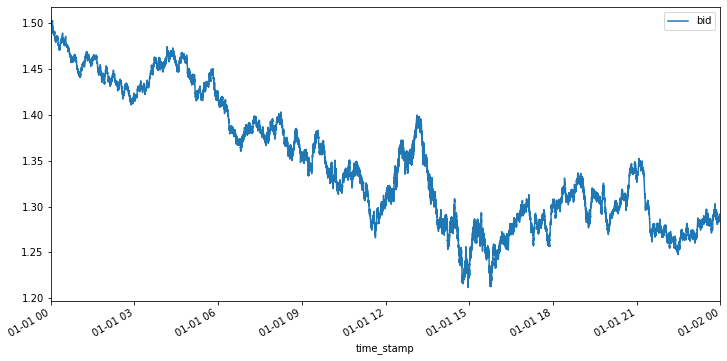

In [34]:
pandas_df[['bid']].plot(figsize=(12,6))

In [35]:
from bokeh.io import output_notebook, show 
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [36]:
p = figure(x_axis_type="datetime", title="USD/GBP Price", plot_height=350, plot_width=800)
p.xgrid.grid_line_color=None
p.ygrid.grid_line_alpha=0.5
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Bid'

p.line(pandas_df.index, pandas_df.bid)

show(p)